from: https://github.com/ymym3412/chariot-PyTorch-Japanese-text-classification, https://ymym3412.hatenablog.com/entry/2019/03/02/043815

In [170]:
import os
from pathlib import Path


titles, articles, labels = [], [], []
news_list = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel', 'livedoor-homme', 'movie-enter', 'peachy', 'smax', 'sports-watch', 'topic-news']
for i, media in enumerate(news_list):
    files = os.listdir(Path('text', media))
    for file_name in files:
        if file_name == 'LICENSE.txt':
            continue
        with Path('text', media, file_name).open(encoding='utf-8') as f:
            lines = [line for line in f]
            title = lines[2].replace('\n', '')
            text = ''.join(lines[3:])
            titles.append(title)
            articles.append(text.replace('\n', ''))
            labels.append(i)

In [171]:
from collections import Counter

counter = Counter(labels)
for com in counter.most_common():
    print(com)

(7, 900)
(0, 870)
(1, 870)
(4, 870)
(6, 870)
(2, 864)
(5, 842)
(8, 770)
(3, 511)


In [127]:
import pandas as pd
df = pd.DataFrame({'title': titles, 'article': articles, 'label': labels})

In [128]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(df[['article', 'title']], df['label'], stratify=df['label'])

In [129]:
train_df = train_X
train_df['label'] = train_y

In [130]:
test_df = test_X
test_df['label'] = test_y

In [6]:
from chariot.transformer.text.base import TextFilter
import re


class RegularExpressionReplacer(TextFilter):

    def __init__(self, pattern, replacement, copy=True):
        super().__init__(copy)
        self.pattern = pattern
        self.replacement = replacement

    def apply(self, text):
        return re.sub(self.pattern, self.replacement, text)

In [132]:
from chariot.dataset_preprocessor import DatasetPreprocessor
from chariot.transformer.formatter import Padding
import chariot.transformer as ct


pad_length = 300

dp = DatasetPreprocessor()
dp.process('article')\
    .by(ct.text.UnicodeNormalizer())\
    .by(ct.text.LowerNormalizer())\
    .by(RegularExpressionReplacer(pattern='■.+?。', replacement=''))\
    .by(ct.text.SymbolFilter())\
    .by(ct.Tokenizer('ja'))\
    .by(ct.token.StopwordFilter('ja'))\
    .by(ct.Vocabulary(min_df=2, max_df=0.8))\
    .by(Padding(length=pad_length))\
    .fit(train_df['article'])

In [133]:
dp.process('label')\
    .by(ct.formatter.CategoricalLabel(num_class=9))

In [134]:
import time


start = time.time()
preprocessed = dp.preprocess(train_df)
end = time.time()
print(end-start)

6037.2364292144775


In [10]:
from chariot.storage import Storage
import os
import sys
from pathlib import Path


def set_path():
    if "../" not in sys.path:
        sys.path.append("../")
    root_dir = Path.cwd()
    return root_dir

ROOT_DIR = set_path()

storage = Storage.setup_data_dir(ROOT_DIR)

In [40]:
_ = storage.chakin(name='fastText(ja)')

Test: 100% ||                                       | Time: 0:07:02   3.1 MiB/s


In [136]:
embedding = dp.process('article').preprocessor.vocabulary.make_embedding(storage.data_path('external/fasttext(ja).vec'))

In [68]:
# これでDatasetPreprocessorの中の特定のカラムのpreprocessorを取得できる
len(dp.process('article').preprocessor.vocabulary.get())

41009

In [155]:
dp.process('article').preprocessor.vocabulary.get()[:10]

['@@PADDING@@',
 '@@UNKNOWN@@',
 '@@BEGIN_OF_SEQUENCE@@',
 '@@END_OF_SEQUENCE@@',
 'できる',
 'その',
 'ので',
 'れる',
 '4',
 'ば']

In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class  CNN_Text(nn.Module):
    
    def __init__(self, pretrained_wv, output_dim, kernel_num, kernel_sizes=[3,4,5], dropout=0.5, static=False):
        super(CNN_Text,self).__init__()
        
        weight = torch.from_numpy(pretrained_wv)
        self.embed = nn.Embedding.from_pretrained(weight, freeze=False)
        self.convs1 = nn.ModuleList([nn.Conv2d(1, kernel_num, (k, self.embed.weight.shape[1])) for k in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(len(kernel_sizes)*kernel_num, output_dim)
        self.static = static

    def conv_and_pool(self, x, conv):
        x = F.relu(conv(x)).squeeze(3) #(N,Co,W)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return x


    def forward(self, x):
        x = self.embed(x) # (N,W,D)
        
        if self.static:
            x = x.detach()

        x = x.unsqueeze(1) # (N,Ci,W,D)
        x = x.float()
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] #[(N,Co,W), ...]*len(Ks)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] #[(N,Co), ...]*len(Ks)

        x = torch.cat(x, 1)
        x = self.dropout(x) # (N,len(Ks)*Co)
        logit = self.fc1(x) # (N,C)
        return logit

In [139]:
# emb_dim = 200
output_dim = 9
kernel_num = 100
kernel_sizes = [3,4,5]
dropout = 0.5

In [140]:
model = CNN_Text(embedding, output_dim, kernel_num, kernel_sizes, dropout)

In [142]:
from tensorboardX import SummaryWriter

writer = SummaryWriter()

In [143]:
import torch
import numpy as np

model = CNN_Text(embedding, output_dim, kernel_num, kernel_sizes, dropout)
use_cuda = True
opt = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()
if use_cuda:
    model = model.cuda()
    
loss_list = []
for b in dp.iterate(preprocessed, batch_size=32, epoch=15):
    feature = torch.LongTensor(b['article'])
    target = torch.LongTensor(np.argmax(b['label'], axis=1))
    if use_cuda:
        feature = feature.cuda()
        target = target.cuda()
        
    opt.zero_grad()
    logit = model(feature)
    loss = F.nll_loss(F.log_softmax(logit), target)
    loss.backward()
    opt.step()
    # scheduler.step()
    writer.add_scalar('data/loss', loss.item())
    print(loss.item())
    loss_list.append(loss.item())
    
    
writer.close()

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


3.908686876296997
6.53703498840332
8.49934196472168
5.575082778930664
4.551190376281738
4.63572883605957
5.356140613555908
4.159955024719238
3.3104329109191895
3.6084940433502197
4.231949806213379
3.4081931114196777
3.317380905151367
3.8675601482391357
3.520000457763672
2.900130033493042
3.7219505310058594
3.2030234336853027
2.916612148284912
2.5631003379821777
2.623995780944824
2.695629835128784
2.088845729827881
2.7131764888763428
2.6223835945129395
2.7717432975769043
2.668119192123413
2.478347063064575
2.445812702178955
2.4585952758789062
2.634215831756592
2.370832681655884
2.31697416305542
2.209430694580078
2.274068832397461
2.3247756958007812
2.144577980041504
2.0964839458465576
2.2006468772888184
2.2078113555908203
2.2306342124938965
2.2013957500457764
2.3126327991485596
2.202878475189209
2.12414813041687
2.217996120452881
2.2077035903930664
2.3940038681030273
2.23445463180542
2.250959873199463
2.226022481918335
2.3074634075164795
2.186197280883789
2.1941797733306885
2.2051837444

0.6645433902740479
0.5608400106430054
0.7373878359794617
0.5973821878433228
0.5212643146514893
0.802060604095459
0.5717999935150146
0.8077632188796997
0.3847845494747162
0.6636732816696167
0.971269965171814
0.42498719692230225
0.7003841400146484
0.4750805199146271
0.7395283579826355
0.6088535189628601
0.7930631637573242
0.5220215320587158
0.6729544401168823
0.6519710421562195
0.6186632513999939
0.7319854497909546
0.43018943071365356
0.6278481483459473
0.48316460847854614
0.41439127922058105
0.5583575963973999
0.5249502062797546
0.9164897203445435
0.5807163715362549
0.6067759990692139
0.7136695384979248
0.7683749198913574
0.6711981296539307
0.6251897811889648
0.46994879841804504
0.8583441376686096
0.8747004270553589
0.7462989091873169
0.5421909689903259
0.8122548460960388
0.507616400718689
0.6161835789680481
0.33108797669410706
0.6169519424438477
0.41976967453956604
0.5169816017150879
0.5183192491531372
0.5453067421913147
0.9552788734436035
0.45676809549331665
0.28474104404449463
0.5564

0.17465990781784058
0.16860412061214447
0.23080991208553314
0.09905803203582764
0.37839391827583313
0.22236786782741547
0.3545977771282196
0.043071456253528595
0.2687760293483734
0.1818767786026001
0.34320178627967834
0.20517699420452118
0.20865340530872345
0.08529296517372131
0.06193479895591736
0.29450997710227966
0.4680137038230896
0.5309024453163147
0.06657809764146805
0.13062794506549835
0.20741286873817444
0.2547186017036438
0.2165786325931549
0.4069320559501648
0.20141270756721497
0.25810036063194275
0.23369741439819336
0.3210936486721039
0.2834164500236511
0.1412401795387268
0.10578679293394089
0.14325806498527527
0.1133812740445137
0.08408327400684357
0.09357111155986786
0.23301829397678375
0.2504997253417969
0.26474934816360474
0.18139749765396118
0.31070899963378906
0.33644184470176697
0.08436024188995361
0.1044108048081398
0.20669011771678925
0.41629981994628906
0.16611942648887634
0.1913629174232483
0.28608438372612
0.17541198432445526
0.12547892332077026
0.312368839979171

0.3512420356273651
0.1454462856054306
0.06086146831512451
0.09840986877679825
0.12439268082380295
0.39249277114868164
0.08368835598230362
0.13694091141223907
0.17271238565444946
0.24319440126419067
0.028723984956741333
0.07421460002660751
0.26232099533081055
0.052260152995586395
0.1353163719177246
0.11534551531076431
0.1842636913061142
0.061740778386592865
0.19215378165245056
0.0782155990600586
0.04745848476886749
0.1643071174621582
0.13221755623817444
0.07010253518819809
0.07263592630624771
0.21472245454788208
0.2501472234725952
0.10755831748247147
0.10542495548725128
0.06481318175792694
0.25798478722572327
0.01700931042432785
0.06819069385528564


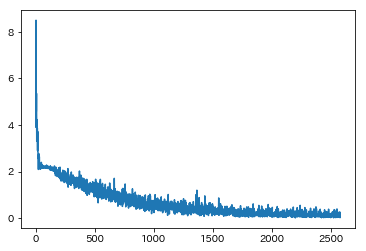

In [3]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

axis = list(range(len(loss_list)))
plt.plot(axis, loss_list)

In [145]:
test_preprocessed = dp(test_df).preprocess().format().processed

In [149]:
model.eval()
feature = torch.LongTensor(test_preprocessed['article']).cuda()
forward = model(feature)

In [150]:
predicted_label = forward.argmax(dim=1).cpu()
test_target = torch.LongTensor(np.argmax(test_preprocessed['label'], axis=1))

In [151]:
from sklearn.metrics import classification_report

print(classification_report(test_target.numpy(), predicted_label.numpy()))

              precision    recall  f1-score   support

           0       0.49      0.56      0.52       218
           1       0.59      0.49      0.54       217
           2       0.47      0.50      0.48       216
           3       0.46      0.48      0.47       128
           4       0.65      0.63      0.64       218
           5       0.46      0.41      0.44       210
           6       0.68      0.78      0.73       218
           7       0.63      0.65      0.64       225
           8       0.61      0.52      0.56       192

   micro avg       0.56      0.56      0.56      1842
   macro avg       0.56      0.56      0.56      1842
weighted avg       0.56      0.56      0.56      1842



In [82]:
from sklearn.metrics import accuracy_score

print(accuracy_score(test_target.numpy(), predicted_label.numpy()))

0.6487513572204126
